# Loading Data

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = 'gs://kds-294933660d0c81513494d27eb2b08c8d51c4e8b945b58ecaeeab7568'
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 100

In [ ]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1057
Pneumonia images count in training set: 3128


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [ ]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


In [ ]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# Visualization

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

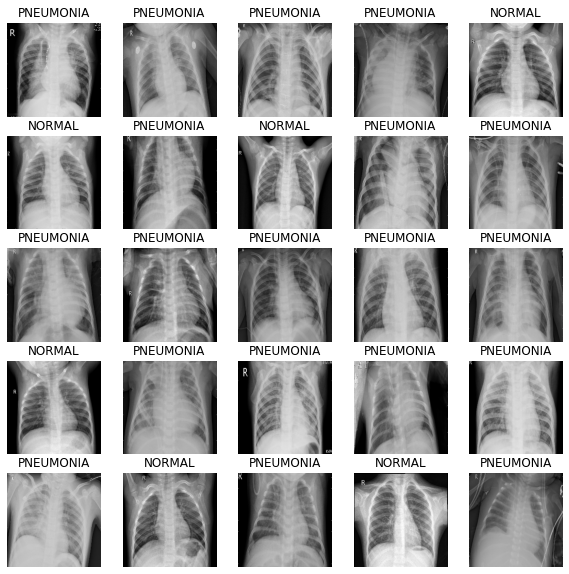

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Models @TPU

In [ ]:
def vggmodel():
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  for layer in model.layers:
	  layer.trainable = False

  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  model = Model(inputs=model.inputs, outputs=output)
  return model   

In [ ]:
def inceptionv3():
  model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224, 224, 3))
  for layer in model.layers:
	  layer.trainable = False

  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  model = Model(inputs=model.inputs, outputs=output)
  return model 

In [ ]:
def Xception():
  model = tf.keras.applications.Xception(include_top=False, input_shape=(224, 224, 3))
  for layer in model.layers:
	  layer.trainable = False

  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  model = Model(inputs=model.inputs, outputs=output)
  return model 

**Correcting data imbalance**

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.08495912])

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.98
Weight for class 1: 0.67


In [ ]:
with strategy.scope():
    model = vggmodel()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("vgg_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb]
)

In [ ]:
model = load_model('/content/vgg_model.h5')

In [ ]:
filename = '/content/covid.jpeg'
image = load_img(filename, target_size=(224, 224))
image = keras.preprocessing.image.img_to_array(image)
image = image.reshape(1,224,224,3)
result = model.predict(image)
print(result[0][0])

1.0


# Web App

In [ ]:
!pip install anvil-uplink

In [ ]:
import anvil.server
anvil.server.connect("AXFKNAYAX7VD7GNH5AL5M6KB-NKHPM4744R6KVXYV")

In [ ]:
model = load_model('/content/drive/My Drive/Covid_vgg16_weights/vgg_model.h5')

In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
  with anvil.media.TempFile(file) as filename:
    image = load_img(filename, target_size=(224, 224))
    image = keras.preprocessing.image.img_to_array(image)
    image = image.reshape(1,224,224,3)
    result = model.predict(image)

    return('Its likely this patient has Coronoa Virus infection' if result == 1 else 'No signs of infection!')